In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
  0%|          | 0/9912422 [00:00<?, ?it/s]

9913344it [00:00, 14730088.55it/s]                            


Extracting input/data\MNIST\raw\train-images-idx3-ubyte.gz to input/data\MNIST\raw


29696it [00:00, 29691073.08it/s]         

Extracting input/data\MNIST\raw\train-labels-idx1-ubyte.gz to input/data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

1649664it [00:00, 8728485.07it/s]                            
  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to input/data\MNIST\raw


5120it [00:00, ?it/s]                   

Extracting input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to input/data\MNIST\raw
Processing...
Done!



c:\Users\CarsonW\AppData\Local\Programs\Python\Python37\lib\site-packages\torchvision\datasets\mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [00:07, 15.25it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

Epoch 1 of 100
Generator loss: 1.34376499, Discriminator loss: 0.92955196


118it [00:06, 19.22it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 11.90it/s]

Epoch 2 of 100
Generator loss: 1.99828878, Discriminator loss: 1.11301541


118it [00:06, 18.43it/s]                         
  2%|▏         | 2/117 [00:00<00:05, 19.23it/s]

Epoch 3 of 100
Generator loss: 6.67953279, Discriminator loss: 0.10153821


118it [00:06, 19.08it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 18.69it/s]

Epoch 4 of 100
Generator loss: 4.70158874, Discriminator loss: 0.55645641


118it [00:06, 19.03it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


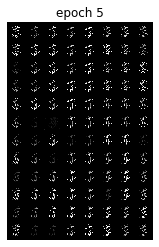

  0%|          | 0/117 [00:00<?, ?it/s]

Epoch 5 of 100
Generator loss: 4.17284070, Discriminator loss: 0.98798882


118it [00:05, 19.77it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 18.87it/s]

Epoch 6 of 100
Generator loss: 3.40186393, Discriminator loss: 1.02780476


118it [00:06, 18.21it/s]                         
  2%|▏         | 2/117 [00:00<00:05, 19.61it/s]

Epoch 7 of 100
Generator loss: 1.16828545, Discriminator loss: 1.30054681


118it [00:06, 18.76it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 8 of 100
Generator loss: 2.34357053, Discriminator loss: 1.05294393


118it [00:06, 17.04it/s]                         
  2%|▏         | 2/117 [00:00<00:05, 19.23it/s]

Epoch 9 of 100
Generator loss: 2.84619116, Discriminator loss: 1.11473368


118it [00:06, 17.51it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


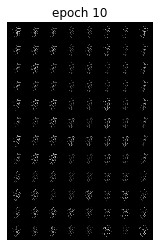

  2%|▏         | 2/117 [00:00<00:07, 14.71it/s]

Epoch 10 of 100
Generator loss: 0.94219883, Discriminator loss: 1.25843838


118it [00:06, 17.34it/s]                         
  2%|▏         | 2/117 [00:00<00:05, 19.61it/s]

Epoch 11 of 100
Generator loss: 1.16585235, Discriminator loss: 1.29237561


118it [00:06, 19.41it/s]                         
  2%|▏         | 2/117 [00:00<00:05, 19.80it/s]

Epoch 12 of 100
Generator loss: 1.58317641, Discriminator loss: 0.74991667


118it [00:06, 18.37it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

Epoch 13 of 100
Generator loss: 2.41397926, Discriminator loss: 0.65947589


118it [00:07, 16.30it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 14 of 100
Generator loss: 2.33487631, Discriminator loss: 0.50659471


118it [00:07, 16.36it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


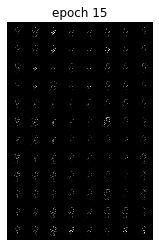

  2%|▏         | 2/117 [00:00<00:06, 18.02it/s]

Epoch 15 of 100
Generator loss: 2.66261838, Discriminator loss: 0.47902604


118it [00:06, 17.83it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 16 of 100
Generator loss: 3.40763027, Discriminator loss: 0.34623839


118it [00:07, 16.50it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

Epoch 17 of 100
Generator loss: 3.59588126, Discriminator loss: 0.39850578


118it [00:07, 16.35it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 18 of 100
Generator loss: 3.01701983, Discriminator loss: 0.32728275


118it [00:07, 16.32it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

Epoch 19 of 100
Generator loss: 3.45708379, Discriminator loss: 0.30750136


118it [00:07, 16.38it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


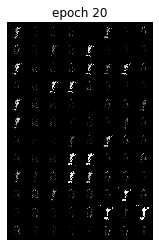

  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

Epoch 20 of 100
Generator loss: 3.41740526, Discriminator loss: 0.38135102


118it [00:07, 16.57it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.49it/s]

Epoch 21 of 100
Generator loss: 3.06136731, Discriminator loss: 0.38046151


118it [00:06, 18.91it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

Epoch 22 of 100
Generator loss: 3.31915725, Discriminator loss: 0.38249189


118it [00:07, 15.61it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.39it/s]

Epoch 23 of 100
Generator loss: 3.75079317, Discriminator loss: 0.40837853


118it [00:07, 16.20it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 24 of 100
Generator loss: 2.96420401, Discriminator loss: 0.52218182


118it [00:07, 16.34it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


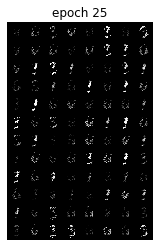

  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 25 of 100
Generator loss: 3.00574965, Discriminator loss: 0.41918038


118it [00:07, 16.36it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

Epoch 26 of 100
Generator loss: 3.37152401, Discriminator loss: 0.38639138


118it [00:07, 16.50it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

Epoch 27 of 100
Generator loss: 3.08526548, Discriminator loss: 0.51520240


118it [00:07, 16.44it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 28 of 100
Generator loss: 3.03114034, Discriminator loss: 0.51986910


118it [00:07, 16.55it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

Epoch 29 of 100
Generator loss: 2.51022226, Discriminator loss: 0.65590246


118it [00:07, 16.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


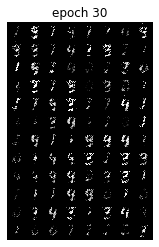

  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 30 of 100
Generator loss: 2.67843557, Discriminator loss: 0.50537416


118it [00:07, 16.47it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

Epoch 31 of 100
Generator loss: 3.07813979, Discriminator loss: 0.43977795


118it [00:07, 16.48it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

Epoch 32 of 100
Generator loss: 2.77113030, Discriminator loss: 0.54599407


118it [00:07, 16.43it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 33 of 100
Generator loss: 2.92972371, Discriminator loss: 0.52259337


118it [00:07, 16.37it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

Epoch 34 of 100
Generator loss: 2.87856756, Discriminator loss: 0.54725230


118it [00:07, 16.35it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


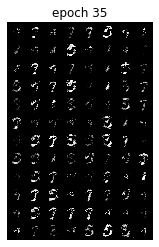

  2%|▏         | 2/117 [00:00<00:07, 15.87it/s]

Epoch 35 of 100
Generator loss: 2.55070547, Discriminator loss: 0.58928065


118it [00:07, 16.34it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

Epoch 36 of 100
Generator loss: 2.74354596, Discriminator loss: 0.54367475


118it [00:06, 17.77it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

Epoch 37 of 100
Generator loss: 2.60032122, Discriminator loss: 0.62091425


118it [00:07, 16.32it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 38 of 100
Generator loss: 2.56916634, Discriminator loss: 0.52901214


118it [00:07, 16.58it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 39 of 100
Generator loss: 2.91327934, Discriminator loss: 0.49616669


118it [00:07, 16.39it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


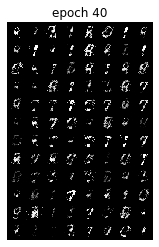

  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 40 of 100
Generator loss: 2.90373623, Discriminator loss: 0.51246751


118it [00:06, 17.49it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.09it/s]

Epoch 41 of 100
Generator loss: 2.99445059, Discriminator loss: 0.53794501


118it [00:06, 19.23it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 18.69it/s]

Epoch 42 of 100
Generator loss: 2.81483284, Discriminator loss: 0.54504727


118it [00:06, 18.61it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

Epoch 43 of 100
Generator loss: 2.97354346, Discriminator loss: 0.49096611


118it [00:06, 19.25it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.70it/s]

Epoch 44 of 100
Generator loss: 2.59852715, Discriminator loss: 0.61781626


118it [00:06, 18.14it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


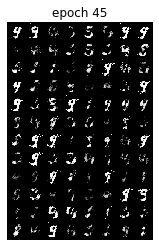

  2%|▏         | 2/117 [00:00<00:09, 11.83it/s]

Epoch 45 of 100
Generator loss: 2.34170709, Discriminator loss: 0.69475566


118it [00:06, 18.92it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 19.05it/s]

Epoch 46 of 100
Generator loss: 2.63785365, Discriminator loss: 0.59259970


118it [00:07, 16.76it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

Epoch 47 of 100
Generator loss: 2.45677406, Discriminator loss: 0.59245422


118it [00:06, 19.49it/s]                         
  2%|▏         | 2/117 [00:00<00:08, 14.22it/s]

Epoch 48 of 100
Generator loss: 2.72233403, Discriminator loss: 0.60540579


118it [00:07, 16.80it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

Epoch 49 of 100
Generator loss: 2.49542843, Discriminator loss: 0.68759982


118it [00:06, 18.12it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


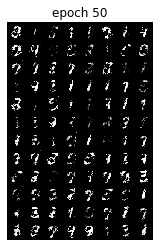

  2%|▏         | 2/117 [00:00<00:06, 18.52it/s]

Epoch 50 of 100
Generator loss: 2.72628343, Discriminator loss: 0.61133910


118it [00:06, 18.70it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

Epoch 51 of 100
Generator loss: 2.66844552, Discriminator loss: 0.59559771


118it [00:07, 16.44it/s]                         
  3%|▎         | 3/117 [00:00<00:05, 20.98it/s]

Epoch 52 of 100
Generator loss: 2.37074684, Discriminator loss: 0.64270333


118it [00:05, 20.04it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

Epoch 53 of 100
Generator loss: 2.79119120, Discriminator loss: 0.55483813


118it [00:05, 20.77it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 18.87it/s]

Epoch 54 of 100
Generator loss: 2.86029333, Discriminator loss: 0.54433334


118it [00:06, 17.82it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


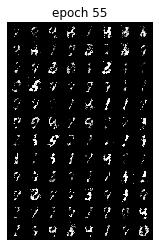

  3%|▎         | 4/117 [00:00<00:05, 19.61it/s]

Epoch 55 of 100
Generator loss: 2.55179860, Discriminator loss: 0.60111123


118it [00:06, 18.37it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

Epoch 56 of 100
Generator loss: 2.69102118, Discriminator loss: 0.57069012


118it [00:06, 17.62it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 17.09it/s]

Epoch 57 of 100
Generator loss: 2.61386415, Discriminator loss: 0.60930065


118it [00:06, 16.92it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 58 of 100
Generator loss: 2.69856022, Discriminator loss: 0.62226461


118it [00:07, 16.71it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 59 of 100
Generator loss: 2.44543542, Discriminator loss: 0.70692993


118it [00:06, 19.40it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


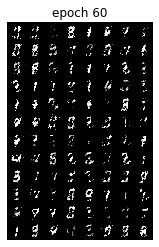

  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

Epoch 60 of 100
Generator loss: 2.62700941, Discriminator loss: 0.67553539


118it [00:06, 19.41it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

Epoch 61 of 100
Generator loss: 2.71052408, Discriminator loss: 0.60025129


118it [00:07, 16.47it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

Epoch 62 of 100
Generator loss: 2.62660491, Discriminator loss: 0.61263567


118it [00:07, 16.26it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 63 of 100
Generator loss: 2.40697300, Discriminator loss: 0.67548122


118it [00:07, 16.33it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

Epoch 64 of 100
Generator loss: 2.46980262, Discriminator loss: 0.65516450


118it [00:06, 19.20it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


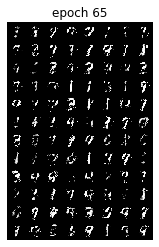

  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

Epoch 65 of 100
Generator loss: 2.47806118, Discriminator loss: 0.65373801


118it [00:07, 16.22it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

Epoch 66 of 100
Generator loss: 2.53425708, Discriminator loss: 0.61757470


118it [00:07, 16.49it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.60it/s]

Epoch 67 of 100
Generator loss: 2.53496263, Discriminator loss: 0.64244683


118it [00:07, 16.42it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

Epoch 68 of 100
Generator loss: 2.51239976, Discriminator loss: 0.64783879


118it [00:07, 16.64it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.75it/s]

Epoch 69 of 100
Generator loss: 2.45480223, Discriminator loss: 0.64757784


118it [00:07, 16.47it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


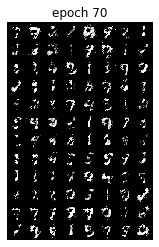

  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

Epoch 70 of 100
Generator loss: 2.27908954, Discriminator loss: 0.69782384


118it [00:07, 16.44it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

Epoch 71 of 100
Generator loss: 2.18772611, Discriminator loss: 0.73114869


118it [00:07, 16.37it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.87it/s]

Epoch 72 of 100
Generator loss: 2.09888776, Discriminator loss: 0.77186148


118it [00:07, 16.33it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

Epoch 73 of 100
Generator loss: 2.03515448, Discriminator loss: 0.79110094


118it [00:07, 16.55it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

Epoch 74 of 100
Generator loss: 2.07891787, Discriminator loss: 0.78398775


118it [00:06, 18.86it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


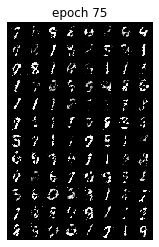

  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

Epoch 75 of 100
Generator loss: 2.18874666, Discriminator loss: 0.72586339


118it [00:06, 16.86it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.39it/s]

Epoch 76 of 100
Generator loss: 2.03951495, Discriminator loss: 0.78059564


118it [00:07, 16.63it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.62it/s]

Epoch 77 of 100
Generator loss: 2.21481277, Discriminator loss: 0.72375142


118it [00:06, 18.12it/s]                         
  3%|▎         | 3/117 [00:00<00:05, 20.55it/s]

Epoch 78 of 100
Generator loss: 2.13604570, Discriminator loss: 0.74064841


118it [00:06, 17.03it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

Epoch 79 of 100
Generator loss: 2.18344691, Discriminator loss: 0.72088954


118it [00:07, 16.72it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


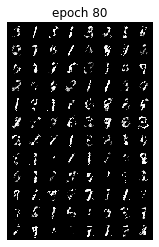

  2%|▏         | 2/117 [00:00<00:07, 15.38it/s]

Epoch 80 of 100
Generator loss: 2.18849199, Discriminator loss: 0.71414384


118it [00:07, 16.28it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.81it/s]

Epoch 81 of 100
Generator loss: 1.97552084, Discriminator loss: 0.81341463


118it [00:07, 16.48it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

Epoch 82 of 100
Generator loss: 1.98182325, Discriminator loss: 0.82231116


118it [00:06, 17.04it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 83 of 100
Generator loss: 1.97019200, Discriminator loss: 0.81577457


118it [00:07, 16.49it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

Epoch 84 of 100
Generator loss: 2.04055126, Discriminator loss: 0.78008553


118it [00:07, 16.55it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


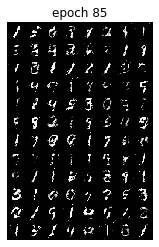

  2%|▏         | 2/117 [00:00<00:07, 15.63it/s]

Epoch 85 of 100
Generator loss: 2.04724279, Discriminator loss: 0.77007159


118it [00:05, 20.39it/s]                         
  2%|▏         | 2/117 [00:00<00:06, 18.18it/s]

Epoch 86 of 100
Generator loss: 2.10206518, Discriminator loss: 0.75821863


118it [00:07, 16.45it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.27it/s]

Epoch 87 of 100
Generator loss: 2.11216667, Discriminator loss: 0.73493461


118it [00:07, 16.24it/s]                         
  2%|▏         | 2/117 [00:00<00:05, 19.26it/s]

Epoch 88 of 100
Generator loss: 2.05692068, Discriminator loss: 0.79853945


118it [00:06, 17.48it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.15it/s]

Epoch 89 of 100
Generator loss: 2.00409801, Discriminator loss: 0.77458660


118it [00:07, 16.37it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


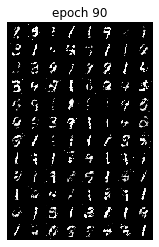

  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

Epoch 90 of 100
Generator loss: 2.03199414, Discriminator loss: 0.76242785


118it [00:07, 16.43it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

Epoch 91 of 100
Generator loss: 1.98541350, Discriminator loss: 0.78202583


118it [00:07, 16.44it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.26it/s]

Epoch 92 of 100
Generator loss: 1.88519543, Discriminator loss: 0.83666535


118it [00:07, 16.61it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

Epoch 93 of 100
Generator loss: 1.96986853, Discriminator loss: 0.80141020


118it [00:07, 16.32it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.13it/s]

Epoch 94 of 100
Generator loss: 1.92419680, Discriminator loss: 0.79716984


118it [00:07, 16.35it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


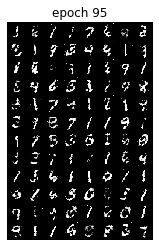

  2%|▏         | 2/117 [00:00<00:07, 14.93it/s]

Epoch 95 of 100
Generator loss: 1.94048673, Discriminator loss: 0.81688699


118it [00:07, 16.30it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 16.00it/s]

Epoch 96 of 100
Generator loss: 1.90939117, Discriminator loss: 0.80549152


118it [00:07, 16.30it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.50it/s]

Epoch 97 of 100
Generator loss: 1.89638863, Discriminator loss: 0.78802641


118it [00:07, 16.32it/s]                         
  2%|▏         | 2/117 [00:00<00:07, 15.04it/s]

Epoch 98 of 100
Generator loss: 1.91802841, Discriminator loss: 0.79892274


118it [00:07, 16.37it/s]                         
  2%|▏         | 2/117 [00:00<00:09, 12.58it/s]

Epoch 99 of 100
Generator loss: 1.94683019, Discriminator loss: 0.82810783


118it [00:07, 16.46it/s]                         
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


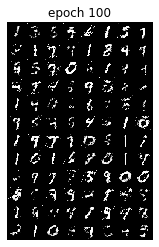

Epoch 100 of 100
Generator loss: 1.91262906, Discriminator loss: 0.86639265


In [14]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    loss = criterion(output, true_label)
    return loss

    ######################################

def discriminator_loss(output, true_label):
    ############ YOUR CODE HERE ##########
    loss = criterion(output, true_label)
    return loss

    ######################################


for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ##########
        X, _ = data
        X = X.to(device)
        batch_size = len(X)

        # Train Discriminator
        optim_d.zero_grad()
        # Real images
        real_labels = label_real(batch_size)
        output_r = discriminator(X)
        d_real_loss = discriminator_loss(output_r, real_labels)
        d_real_loss.backward()

        # Fake images
        noise = create_noise(batch_size, nz)
        fake_X = generator(noise)
        fake_labels = label_fake(batch_size)
        output_f = discriminator(fake_X)
        d_fake_loss = discriminator_loss(output_f, fake_labels)
        d_fake_loss.backward()

        optim_d.step()
        loss_d += (d_real_loss.item() + d_fake_loss.item())

        # Train Generator
        optim_g.zero_grad()
        noise = create_noise(batch_size, nz)
        fake_X = generator(noise)
        output_g = discriminator(fake_X)
        g_loss = generator_loss(output_g, real_labels)
        g_loss.backward()
        optim_g.step()
        loss_g += g_loss.item()


        ######################################


    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # make the images as grid
    generated_img = make_grid(generated_img)

    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [15]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [16]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

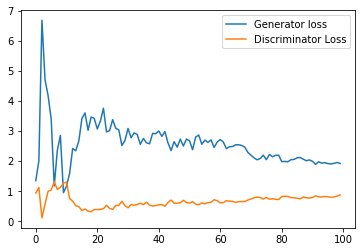

In [17]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')